In [1]:
import importlib.util
import numpy as np
from scipy.constants import c
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

interApi = lumapi.INTERCONNECT(hide = False)

In [3]:
um = 1e-6
nm = 1e-9
valor_lambda = 1550*nm
start_wavelenth = 1500*nm
stop_wavelenth = 1600*nm
number_point = 100000
wg_width = 0.5*um
radius = 5*um
ng = 4.325928

file = 'ring_ressonator_PDK'

In [4]:
FSR = [1*nm, 10*nm, 20*nm]

In [5]:
def calcular_Lc (valor_Lr):
    valor_Lc = valor_Lr - 2*np.pi*radius
    return valor_Lc

In [6]:
def calcular_Lr (valor_fsr):
    Valor_Lr = (valor_lambda**2)/(ng*valor_fsr)
    return Valor_Lr

In [7]:
def calcular_fsr (valor_Lr):
    valor_fsr = (valor_lambda**2) / (ng * valor_Lr)
    return valor_fsr

In [8]:
Lc = np.zeros(len(FSR))
num_anel = [1, 1, 1]

In [9]:
Lc_pdk = 14*um
Lr = calcular_Lr(FSR[0])
Lc[0] = calcular_Lc(Lr - 2*Lc_pdk)/2

if Lc[0] < 0:
    Lc[0] = 0

print(f'Para FSR = {FSR[0]/nm:.2f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento = {Lc[0]/um:.2f}\u03BCm\nNumero de anéis: {num_anel[0]}\n')

Para FSR = 1.00nm:
Comprimento aproximado do anel = 555.37μm
Comprimento de acoplamento = 247.98μm
Numero de anéis: 1



In [10]:
primeiro = 2
ultimo = primeiro + 9
passo = 10

m1 = np.linspace(primeiro, ultimo, passo)
m2 = m1 - 1

In [11]:
Lr1 = np.zeros(len(m1))
Lr2 = np.zeros(len(m2))

Lc1 = 0
Lc2 = 0

In [12]:
x_ona = 0
y_ona = 0

x_acoplador_direcional_sup = 20
y_acoplador_direcional_sup = 200

x_acoplador_direcional_inf = 20
y_acoplador_direcional_inf = 600

distancia = 200

x_waveguide_esquerdo = x_acoplador_direcional_sup - distancia
y_waveguide_esquerdo = y_acoplador_direcional_sup + distancia

x_waveguide_direito = x_acoplador_direcional_sup + distancia
y_waveguide_direito = y_acoplador_direcional_sup + distancia



In [13]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/(start_wavelenth))
interApi.set('stop frequency', c/(stop_wavelenth))
interApi.set('number of points', number_point)

In [14]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_1')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_1')
interApi.setposition(f'Acoplador_Direcional_sup_1', x_acoplador_direcional_sup, y_acoplador_direcional_sup)
interApi.set('coupling_length', Lc_pdk)

interApi.select(f'Acoplador_Direcional_inf_1')
interApi.delete()
    
interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_1')
interApi.setposition(f'Acoplador_Direcional_inf_1', x_acoplador_direcional_inf, y_acoplador_direcional_inf)
interApi.set('coupling_length', Lc_pdk)

In [15]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_1')
interApi.delete()
interApi.select(f'WGD_direito_1')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_1')
interApi.setposition(f'WGD_esquerdo_1', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('wg_length', Lc[0])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_1')
interApi.setposition(f'WGD_direito_1', x_waveguide_direito, y_waveguide_direito)
interApi.set('wg_length', Lc[0])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [16]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_1', 'opt_1')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_2', f'WGD_esquerdo_1', 'port 1')
interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_4', f'WGD_direito_1', 'port 1')

interApi.connect(f'WGD_esquerdo_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_1')
interApi.connect(f'WGD_direito_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')

1.0

In [17]:
interApi.save(file)

In [18]:
interApi.run(1)

In [19]:
def plot_valores(FSR):

    wavelength = np.array(FSR['wavelength']).flatten()
    transmission = np.array(FSR["'TE' gain (dB)"])

    return wavelength, transmission

In [20]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)

wavelength_2, transmission_2 = plot_valores(FSR_2)

In [21]:
def calcular_fsr_medio(wavelength, transmission, threshold=-17.25):
    minimos, _ = find_peaks(-transmission)
    vales = [idx for idx in minimos if transmission[idx] < threshold]
    if len(vales) < 2:
        return None

    vales_wavelengths = wavelength[vales]

    distancias_entre_vales = -np.diff(vales_wavelengths)

    fsr_medio = np.median(distancias_entre_vales)

    return fsr_medio

In [22]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [23]:
if fsr_medio < FSR[0]/nm:
    while fsr_medio < FSR[0]/nm*0.99:
        interApi.switchtolayout()
        Lc[0] = Lc[0] - 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[0])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[0])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)
        if Lc[0] < 0:
            print('Não é possível construir com apenas um anel')
            Lc[0] = 0
            break
        
else:
    while fsr_medio > FSR[0]/nm*1.01:
        interApi.switchtolayout()
        Lc[0] = Lc[0] + 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[0])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[0])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [24]:
print(f'O novo comprimento de acoplamento é de:{Lc[0]/um:.2f}\u03BCm')

O novo comprimento de acoplamento é de:260.98μm


In [25]:
def y_min(value):
    return round(value / 3) * 3

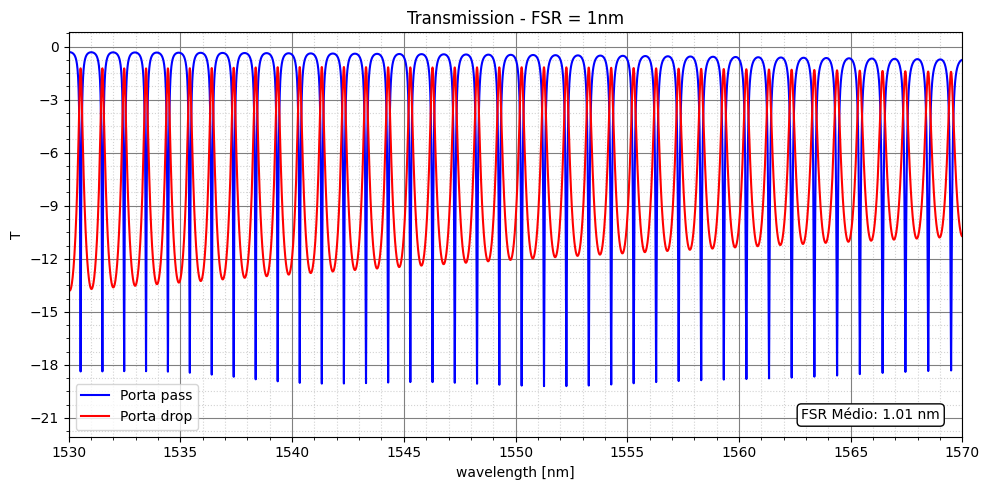

In [26]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Transmission - FSR = 1nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax1.get_xlim()[1]-1, ax1.get_ylim()[0]+1),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm.png')
plt.show()

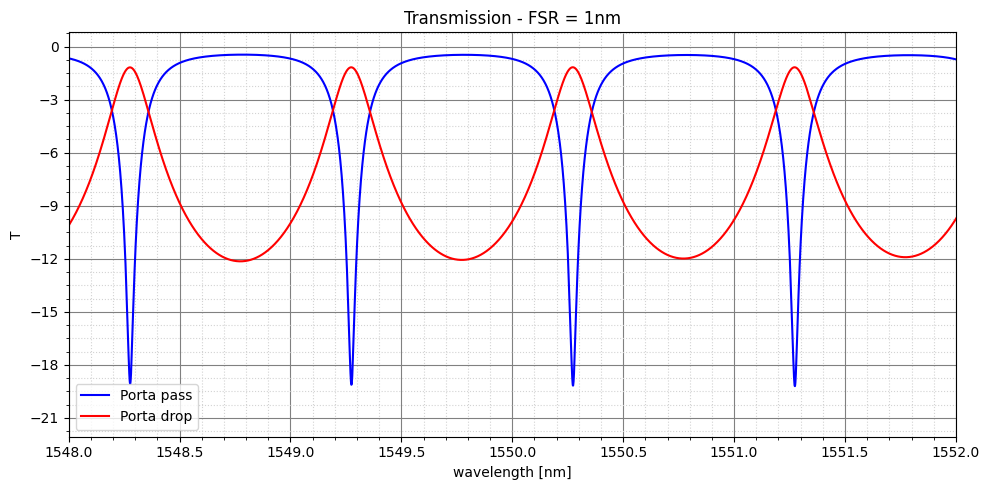

In [27]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([1548, 1552])
plt.title(r'Transmission - FSR = 1nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm - zoom.png')
plt.show()

In [28]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_1 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_1 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_1 = np.array(FSR_2["'TE' free spectral range (m)"])

fsrplot_2_1[0] = fsrplot_1_1[0]

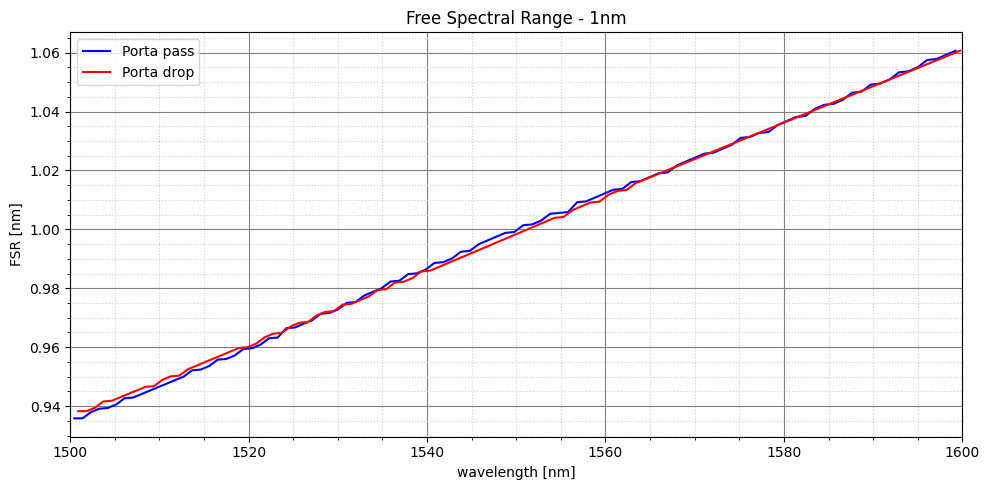

In [29]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, (stop_wavelenth)/nm])
plt.title(r'Free Spectral Range - 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 1nm.png')
plt.show()

In [30]:
Lc_pdk = 14*um
Lr = calcular_Lr(FSR[1])
Lc[1] = calcular_Lc(Lr - 2*Lc_pdk)/2

if Lc[1] < 0:
    Lc[1] = 0

print(f'Para FSR = {FSR[1]/nm:.2f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento = {Lc[1]/um:.2f}\u03BCm\nNumero de anéis: {num_anel[1]}\n')

Para FSR = 10.00nm:
Comprimento aproximado do anel = 55.54μm
Comprimento de acoplamento = 0.00μm
Numero de anéis: 1



In [31]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_1')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_1')
interApi.setposition(f'Acoplador_Direcional_sup_1', x_acoplador_direcional_sup, y_acoplador_direcional_sup)
interApi.set('coupling_length', Lc_pdk)

interApi.select(f'Acoplador_Direcional_inf_1')
interApi.delete()
    
interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_1')
interApi.setposition(f'Acoplador_Direcional_inf_1', x_acoplador_direcional_inf, y_acoplador_direcional_inf)
interApi.set('coupling_length', Lc_pdk)

In [32]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_1')
interApi.delete()
interApi.select(f'WGD_direito_1')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_1')
interApi.setposition(f'WGD_esquerdo_1', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('wg_length', Lc[1])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_1')
interApi.setposition(f'WGD_direito_1', x_waveguide_direito, y_waveguide_direito)
interApi.set('wg_length', Lc[1])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [33]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_1', 'opt_1')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_2', f'WGD_esquerdo_1', 'port 1')
interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_4', f'WGD_direito_1', 'port 1')

interApi.connect(f'WGD_esquerdo_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_1')
interApi.connect(f'WGD_direito_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')

1.0

In [34]:
interApi.save(file)

In [35]:
interApi.run(1)

In [36]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [37]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [38]:
if fsr_medio < FSR[1]/nm:
    while fsr_medio < FSR[1]/nm*0.98:
        interApi.switchtolayout()
        Lc[1] = Lc[1] - 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[1])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[1])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)
        if Lc[1] < 0:
            print('Não é possível construir com apenas um anel')
            Lc[1] = 0
            break
        
else:
    while fsr_medio > FSR[1]/nm*1.02:
        interApi.switchtolayout()
        Lc[1] = Lc[1] + 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[1])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[1])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [39]:
print(f'O novo comprimento de acoplamento é de:{Lc[1]/um:.2f}\u03BCm')

O novo comprimento de acoplamento é de:2.50μm


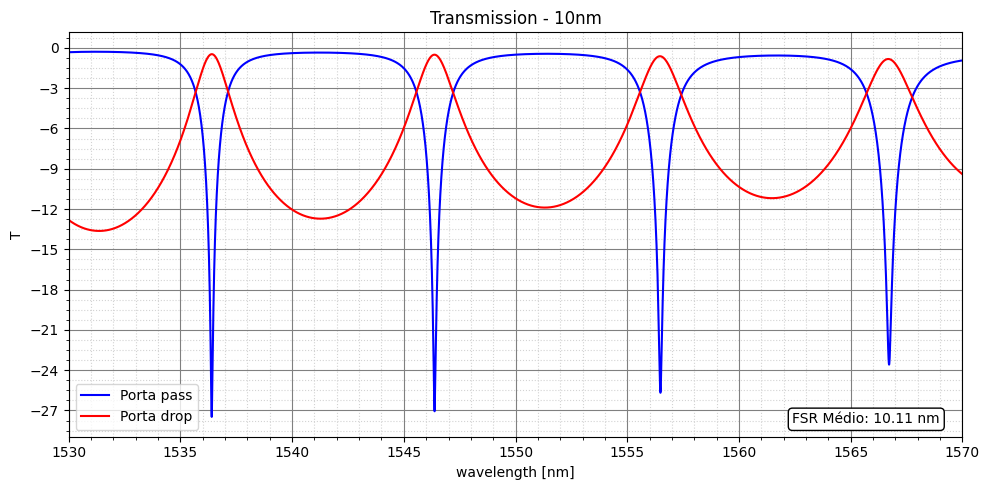

In [40]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Transmission - 10nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax2.get_xlim()[1]-1, ax2.get_ylim()[0]+1),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 10nm.png')
plt.show()

In [41]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_10 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_10 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_10 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_10 = np.array(FSR_2["'TE' free spectral range (m)"])

fsrplot_2_10[0] = fsrplot_1_10[0]

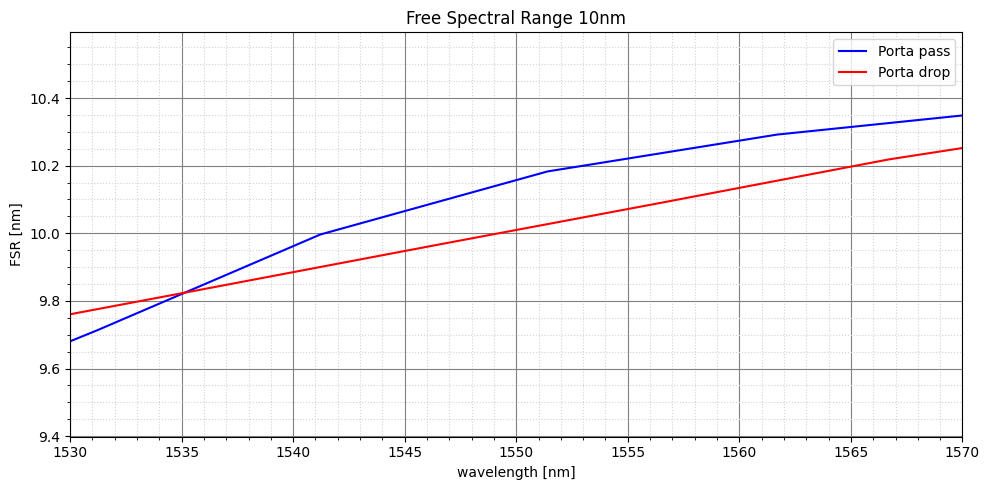

In [42]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Free Spectral Range 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 10nm.png')
plt.show()

In [43]:
Lc_pdk = 14*um
Lr = calcular_Lr(FSR[2])
Lc[2] = calcular_Lc(Lr - 2*Lc_pdk)/2

if Lc[2] < 0:
    Lc[2] = 0

print(f'Para FSR = {FSR[2]/nm:.2f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento = {Lc[2]/um:.2f}\u03BCm\nNumero de anéis: {num_anel[2]}\n')

Para FSR = 20.00nm:
Comprimento aproximado do anel = 27.77μm
Comprimento de acoplamento = 0.00μm
Numero de anéis: 1



In [44]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_1')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_1')
interApi.setposition(f'Acoplador_Direcional_sup_1', x_acoplador_direcional_sup, y_acoplador_direcional_sup)
interApi.set('coupling_length', Lc_pdk)

interApi.select(f'Acoplador_Direcional_inf_1')
interApi.delete()
    
interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_1')
interApi.setposition(f'Acoplador_Direcional_inf_1', x_acoplador_direcional_inf, y_acoplador_direcional_inf)
interApi.set('coupling_length', Lc_pdk)

In [45]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_1')
interApi.delete()
interApi.select(f'WGD_direito_1')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_1')
interApi.setposition(f'WGD_esquerdo_1', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('wg_length', Lc[2])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_1')
interApi.setposition(f'WGD_direito_1', x_waveguide_direito, y_waveguide_direito)
interApi.set('wg_length', Lc[2])
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [46]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_1', 'opt_1')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_2', f'WGD_esquerdo_1', 'port 1')
interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_4', f'WGD_direito_1', 'port 1')

interApi.connect(f'WGD_esquerdo_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_1')
interApi.connect(f'WGD_direito_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')


1.0

In [47]:
interApi.save(file)

In [48]:
interApi.run(1)

In [49]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [50]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [51]:
if fsr_medio < FSR[2]/nm:
    while fsr_medio < FSR[2]/nm*0.99:
        interApi.switchtolayout()
        Lc[2] = Lc[2] - 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[2])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[2])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)
        if Lc[2] < 0:
            print('Não é possível construir com apenas um anel')
            Lc[2] = 0
            num_anel[2] = 2
            break
        
else:
    while fsr_medio > FSR[1]/nm*1.01:
        interApi.switchtolayout()
        Lc[2] = Lc[2] + 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc[2])
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc[2])
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1, transmission_1 = plot_valores(FSR_1)
        wavelength_2, transmission_2 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

Não é possível construir com apenas um anel


In [52]:
FSR1 = np.zeros(len(m1))
FSR2 = np.zeros(len(m2))

for i in range (len(m1)):
    FSR1[i] = FSR[2]/m1[i]
    FSR2[i] = FSR[2]/m2[i]

In [53]:
for i in range (len(m1)):
    Lr1[i] = calcular_Lr(FSR1[i])
    Lr2[i] = calcular_Lr(FSR2[i])

In [54]:
for i in range (len(m1)):
    Lc1 = calcular_Lc(Lr1[i])/2
    Lc2 = calcular_Lc(Lr2[i])/2

    if Lc1 > 0 and Lc2 > 0:
        FSR_total = abs(m2[i] - m1[i]) * (FSR1[i] * FSR2[i]) / abs(FSR1[i] - FSR2[i])
        print(f'{FSR_total/nm:.1f}')
        indx = i
        break

print(f'Para FSR = {FSR[2]/nm:.2f}nm:')
print(f'O anel 2 com FSR = {FSR1[indx]/nm:.1f}nm\nO anel 1 com FSR = {FSR2[indx]/nm:.1f}nm')

20.0
Para FSR = 20.00nm:
O anel 2 com FSR = 6.7nm
O anel 1 com FSR = 10.0nm


In [55]:
FSR_acopla = [round(FSR2[indx]/nm, 1)*nm, round(FSR1[indx]/nm, 1)*nm]

In [56]:
Lc_pdk = 14*um

In [57]:
Lr = calcular_Lr(FSR_acopla[0])
Lc1 = calcular_Lc(Lr - 2*Lc_pdk)/2

if Lc1 < 0:
    Lc1= 0

print(f'Para FSR = {FSR_acopla[0]/nm:.1f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento = {Lc1/um:.2f}\u03BCm\n')

Para FSR = 10.0nm:
Comprimento aproximado do anel = 55.54μm
Comprimento de acoplamento = 0.00μm



In [58]:
Lr = calcular_Lr(FSR_acopla[1])
Lc2 = calcular_Lc(Lr - 2*Lc_pdk)/2

if Lc2 < 0:
    Lc2= 0

print(f'Para FSR = {FSR_acopla[1]/nm:.1f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento = {Lc2/um:.2f}\u03BCm\n')

Para FSR = 6.7nm:
Comprimento aproximado do anel = 82.89μm
Comprimento de acoplamento = 11.74μm



In [59]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_1')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_1')
interApi.setposition(f'Acoplador_Direcional_sup_1', x_acoplador_direcional_sup, y_acoplador_direcional_sup)
interApi.set('coupling_length', Lc_pdk)

interApi.select(f'Acoplador_Direcional_inf_1')
interApi.delete()
    
interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_1')
interApi.setposition(f'Acoplador_Direcional_inf_1', x_acoplador_direcional_inf, y_acoplador_direcional_inf)
interApi.set('coupling_length', Lc_pdk-7*um)

In [60]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_1')
interApi.delete()
interApi.select(f'WGD_direito_1')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_1')
interApi.setposition(f'WGD_esquerdo_1', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('wg_length', Lc2)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_1')
interApi.setposition(f'WGD_direito_1', x_waveguide_direito, y_waveguide_direito)
interApi.set('wg_length', Lc2)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [61]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_1', 'opt_1')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_2', f'WGD_esquerdo_1', 'port 1')
interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_4', f'WGD_direito_1', 'port 1')

interApi.connect(f'WGD_esquerdo_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_1')
interApi.connect(f'WGD_direito_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')

1.0

In [62]:
interApi.save(file)

In [63]:
interApi.run(1)

In [64]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1_6, transmission_1_6 = plot_valores(FSR_1)

wavelength_2_6, transmission_2_6 = plot_valores(FSR_2)

In [65]:
fsr_medio = calcular_fsr_medio(wavelength_1_6/nm, transmission_1_6*6)

In [66]:
if fsr_medio < FSR_acopla[1]/nm:
    while fsr_medio < FSR_acopla[1]*0.99/nm:
        interApi.switchtolayout()
        Lc2 = Lc2 - 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc2)
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc2)
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1_6, transmission_1_6 = plot_valores(FSR_1)
        wavelength_2_6, transmission_2_6 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1_6/nm, transmission_1_6*6)
        if Lc2 < 0:
            print('Não é possível construir com apenas um anel')
            Lc2 = 0
            break
        
else:
    while fsr_medio > FSR_acopla[1]*1.01/nm:
        interApi.switchtolayout()
        Lc2 = Lc2 + 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc2)
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc2)
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1_6, transmission_1_6 = plot_valores(FSR_1)
        wavelength_2_6, transmission_2_6 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1_6/nm, transmission_1_6*6)

In [67]:
print(f'O novo comprimento de acoplamento é de:{Lc2/um:.2f}\u03BCm')

O novo comprimento de acoplamento é de:20.24μm


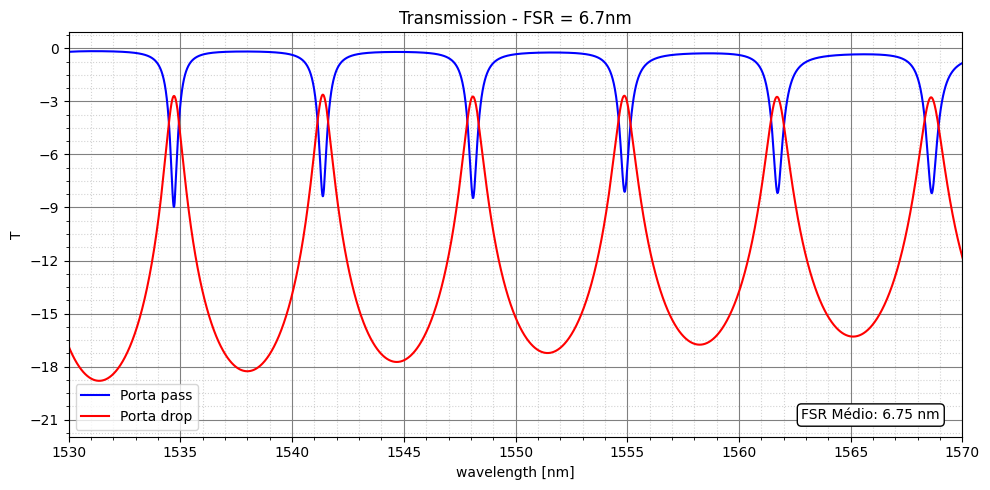

In [68]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1_6/nm, transmission_1_6, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_6/nm, transmission_2_6, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Transmission - FSR = 6.7nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_2_6.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax3.get_xlim()[1]-1, ax3.get_ylim()[0]+1),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 6.7nm.png')
plt.show()

In [69]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_1')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_1')
interApi.setposition(f'Acoplador_Direcional_sup_1', x_acoplador_direcional_sup, y_acoplador_direcional_sup)
interApi.set('coupling_length', Lc_pdk)

interApi.select(f'Acoplador_Direcional_inf_1')
interApi.delete()
    
interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_1')
interApi.setposition(f'Acoplador_Direcional_inf_1', x_acoplador_direcional_inf, y_acoplador_direcional_inf)
interApi.set('coupling_length', Lc_pdk-7*um)

In [70]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_1')
interApi.delete()
interApi.select(f'WGD_direito_1')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_1')
interApi.setposition(f'WGD_esquerdo_1', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('wg_length', Lc1)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_1')
interApi.setposition(f'WGD_direito_1', x_waveguide_direito, y_waveguide_direito)
interApi.set('wg_length', Lc1)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [71]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_1', 'opt_1')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_2', f'WGD_esquerdo_1', 'port 1')
interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_4', f'WGD_direito_1', 'port 1')

interApi.connect(f'WGD_esquerdo_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_1')
interApi.connect(f'WGD_direito_1', 'port 2', f'Acoplador_Direcional_inf_1', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_1', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')

1.0

In [72]:
interApi.save(file)

In [73]:
interApi.run(1)

In [74]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1_10, transmission_1_10 = plot_valores(FSR_1)

wavelength_2_10, transmission_2_10 = plot_valores(FSR_2)

In [75]:
fsr_medio = calcular_fsr_medio(wavelength_1_10/nm, transmission_1_10*6)

In [76]:
if fsr_medio < FSR_acopla[0]/nm:
    while fsr_medio < FSR_acopla[0]/nm+0.3:
        interApi.switchtolayout()
        Lc1 = Lc1 - 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc1)
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc1)
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1_10, transmission_1_10 = plot_valores(FSR_1)
        wavelength_2_10, transmission_2_10 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1_10/nm, transmission_1_10*6)
        if Lc1 < 0:
            print('Não é possível construir com apenas um anel')
            Lc1 = 0
            break
        
else:
    while fsr_medio > FSR_acopla[0]/nm+0.3:
        interApi.switchtolayout()
        Lc1 = Lc1 + 0.5*um
        interApi.setnamed('WGD_esquerdo_1', 'wg_length', Lc1)
        interApi.setnamed('WGD_direito_1', 'wg_length', Lc1)
        interApi.save(file)
        interApi.run(1)
        FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')
        wavelength_1_10, transmission_1_10 = plot_valores(FSR_1)
        wavelength_2_10, transmission_2_10 = plot_valores(FSR_2)
        fsr_medio = calcular_fsr_medio(wavelength_1_10/nm, transmission_1_10*6)

In [77]:
print(f'O novo comprimento de acoplamento é de:{Lc1/um:.2f}\u03BCm')

O novo comprimento de acoplamento é de:6.00μm


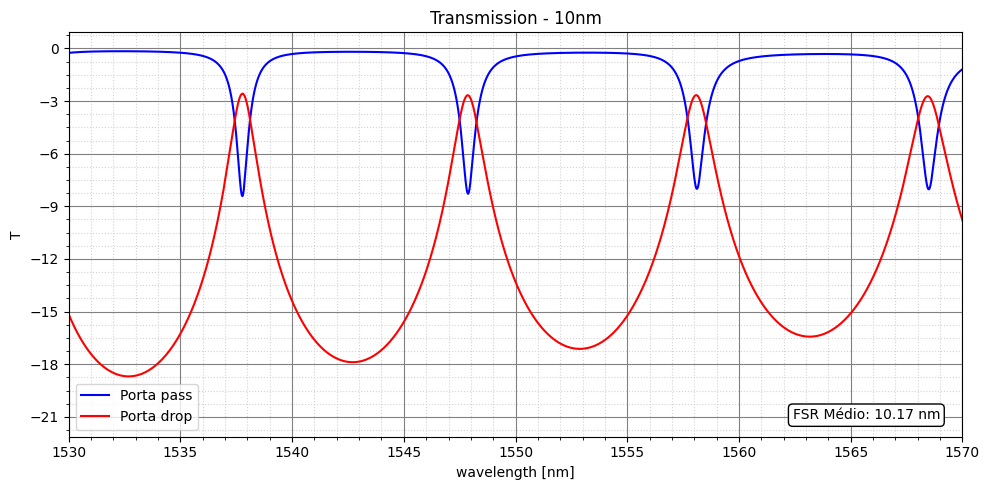

In [78]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(111)

plt.plot(wavelength_1_10/nm, transmission_1_10, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_10/nm, transmission_2_10, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Transmission - 10nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_2_10.min()), 0.01, 3))

fsr_medio = calcular_fsr_medio(wavelength_1_10/nm, transmission_1_10*6)

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax4.get_xlim()[1]-1, ax4.get_ylim()[0]+1),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.show()

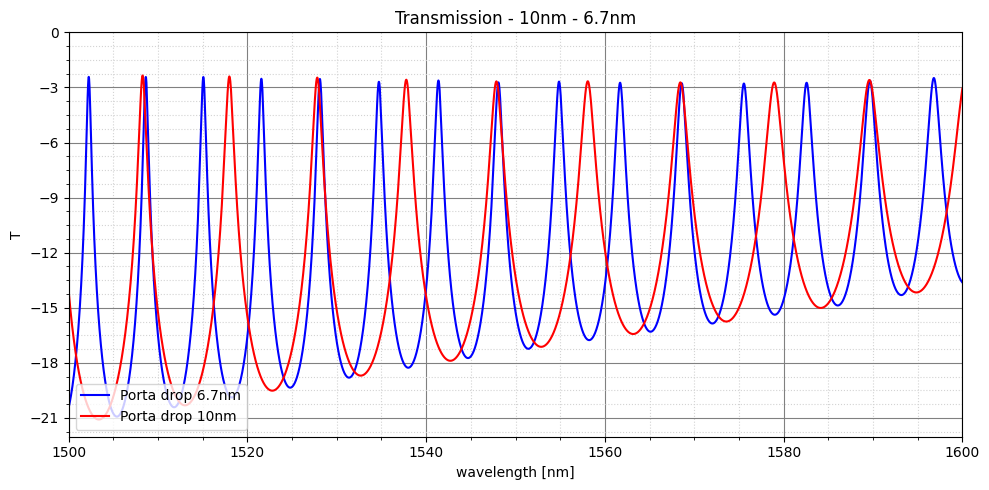

In [79]:
fig5 = plt.figure(figsize=(10,5))
ax5 = fig5.add_subplot(111)

plt.plot(wavelength_2_6/nm, transmission_2_6, label = 'Porta drop 6.7nm', linewidth=1.5, color='blue')
plt.plot(wavelength_2_10/nm, transmission_2_10, label = 'Porta drop 10nm', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - 10nm - 6.7nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_2_10.min()), 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 10-6.7nm.png')
plt.show()

In [80]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_10 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_10 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_10 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_10 = np.array(FSR_2["'TE' free spectral range (m)"])

fsrplot_2_10[0] = fsrplot_1_10[0]

In [81]:
interApi.switchtolayout()

interApi.setnamed('Acoplador_Direcional_inf_1', 'coupling_length', Lc_pdk-10*um)

interApi.select(f'Acoplador_Direcional_inf_2')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_inf_2')
interApi.setposition(f'Acoplador_Direcional_inf_2', x_acoplador_direcional_inf, y_acoplador_direcional_inf + 2*distancia)
interApi.set('coupling_length', Lc_pdk-2*um)

In [82]:
interApi.switchtolayout()

interApi.select(f'WGD_esquerdo_2')
interApi.delete()
interApi.select(f'WGD_direito_2')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_esquerdo_2')
interApi.setposition(f'WGD_esquerdo_2', x_waveguide_esquerdo, y_waveguide_esquerdo + i*2*distancia)
interApi.set('wg_length', 20.385*um)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', f'WGD_direito_2')
interApi.setposition(f'WGD_direito_2', x_waveguide_direito, y_waveguide_direito + i*2*distancia)
interApi.set('wg_length', 20.385*um)
interApi.set('wg_width', wg_width)
interApi.set('Rotated', 45)

In [83]:
interApi.disconnect(f'Acoplador_Direcional_inf_1', 'opt_2', 'ONA', 'input 2')

interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_2', f'WGD_esquerdo_2', 'port 1')
interApi.connect(f'Acoplador_Direcional_inf_1', 'opt_4', f'WGD_direito_2', 'port 1')
interApi.connect(f'WGD_esquerdo_2', 'port 2', f'Acoplador_Direcional_inf_2', 'opt_1')
interApi.connect(f'WGD_direito_2', 'port 2', f'Acoplador_Direcional_inf_2', 'opt_3')
interApi.connect(f'Acoplador_Direcional_inf_2', 'opt_4', 'ONA', 'input 2')

1.0

In [84]:
interApi.save(file)
interApi.run(1)

In [85]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [86]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

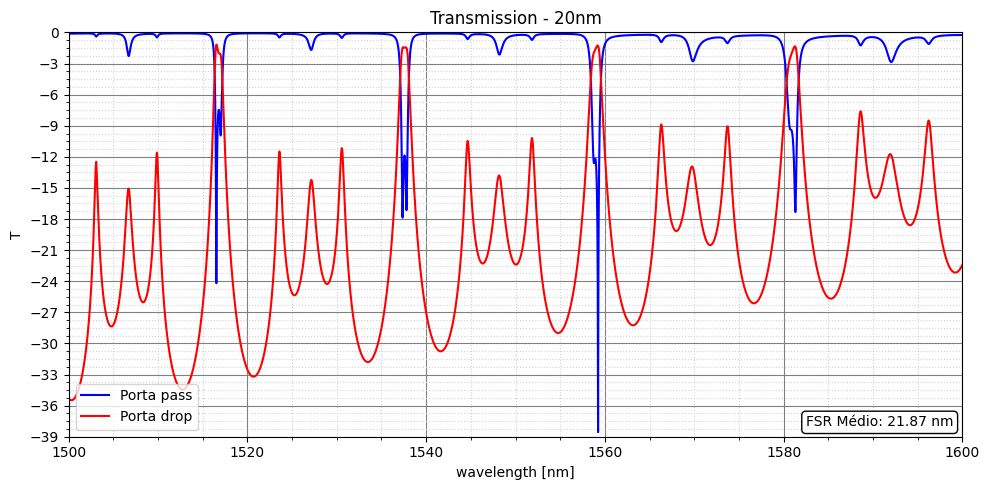

In [87]:
fig6 = plt.figure(figsize=(10,5))
ax6 = fig6.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.ylim(-36, 0.01)
plt.title(r'Transmission - 20nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax6.get_xlim()[1]-1, ax6.get_ylim()[0]+1),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 20nm.png')
plt.show()

In [108]:
Lr1 = 2*np.pi*radius + interApi.getnamed('Acoplador_Direcional_sup_1', 'coupling_length') + interApi.getnamed('Acoplador_Direcional_inf_1', 'coupling_length') + 2*interApi.getnamed('WGD_esquerdo_1', 'wg_length')
Lr2 = 2*np.pi*radius + interApi.getnamed('Acoplador_Direcional_inf_1', 'coupling_length') + interApi.getnamed('Acoplador_Direcional_inf_2', 'coupling_length') + 2*interApi.getnamed('WGD_esquerdo_2', 'wg_length')

print(F'Comprimento aproximado do anel 1 = {Lr1/um:.2f}\u03BCm\nComprimento aproximado do anel 2= {Lr2/um:.2f}\u03BCm\n')

Comprimento aproximado do anel 1 = 61.42μm
Comprimento aproximado do anel 2= 88.19μm



In [88]:
def valores_plot (wavelength, transmission, valor):
    picos, _ = find_peaks(transmission, height=valor, distance=1000)
    wavelength_fsr = (wavelength[picos][:-1] + wavelength[picos][1:]) / 2
    fsrplot = abs(np.diff(wavelength[picos]))
    return wavelength_fsr, fsrplot

In [89]:
wavelength_1_20, fsrplot_1_20 = valores_plot (wavelength_1, -transmission_1, 15)
wavelength_2_20, fsrplot_2_20 = valores_plot (wavelength_2, transmission_2, -2)

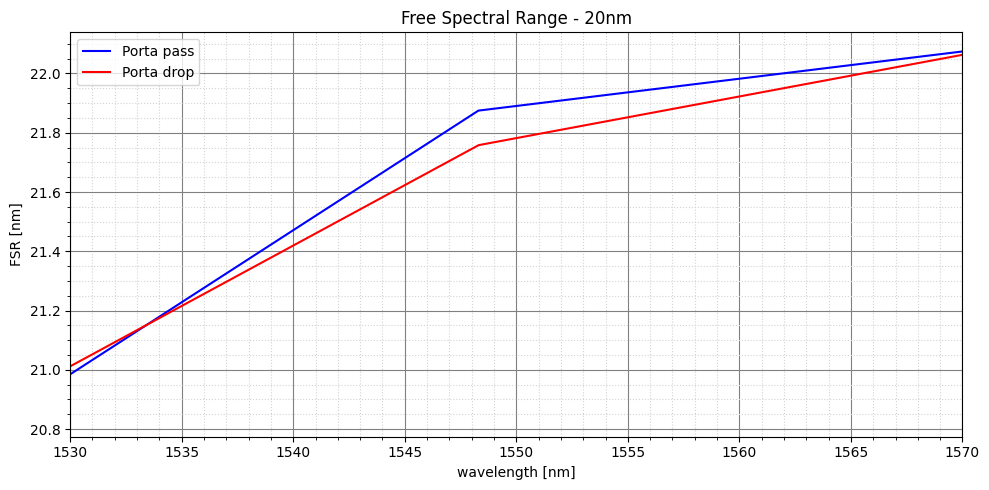

In [90]:
fig6 = plt.figure(figsize=(10,5))
ax6 = fig6.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Free Spectral Range - 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 20nm.png')
plt.show()

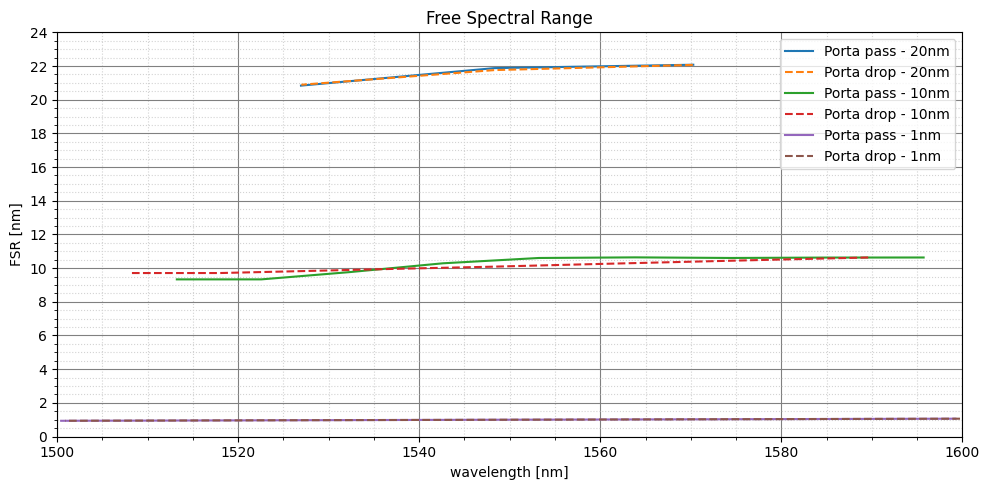

In [91]:
fig7 = plt.figure(figsize=(10,5))
ax7 = fig7.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass - 20nm', linewidth=1.5)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop - 20nm', linewidth=1.5, linestyle='--')
plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass - 10nm', linewidth=1.5)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop - 10nm', linewidth=1.5, linestyle='--')
plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass - 1nm', linewidth=1.5)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop - 1nm', linewidth=1.5, linestyle='--')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.ylim([-0.01, 24])
plt.title(r'Free Spectral Range')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(0, 24.01, 2))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR.png')
plt.show()